<a href="https://colab.research.google.com/github/ktxdev/NLP-Prac/blob/main/Deep%20Learning%3A%20Sentiment%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import nltk
import random
import numpy as np

from nltk.corpus import movie_reviews

In [ ]:
nltk.download('stopwords')
nltk.download('movie_reviews')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


True

In [40]:
documents = [ (' '.join(list(movie_reviews.words(fileid))), category)
  for category in movie_reviews.categories()
  for fileid in movie_reviews.fileids(category)]

documents = [(text, 1) if label == "pos" else (text, 0) for (text, label) in documents]

random.shuffle(documents)

## Train-Test Split

In [41]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(documents, test_size=0.1, random_state=42)

print(len(train_set), len(test_set))

1800 200


## Prepare Input and Output Tensors

In [42]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import Model, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Bidirectional, Concatenate, Attention, GlobalAveragePooling1D

In [43]:
## Split data into X (texts) and y (labels)
texts = [n for (n, l) in train_set]
labels = [l for (n, l) in train_set]
print(len(texts))
print(len(labels))

1800
1800


## Tokenizer

In [44]:
NUM_WORDS = 10000
tokenizer = Tokenizer(num_words=NUM_WORDS) # The tokenizer will automatically include only the most frequent 10000 words in the later text vectorization
tokenizer.fit_on_texts(texts)

## Vocabulary

In [45]:
vocab_size = tokenizer.num_words + 1
print('Vocabulary size: %d' % vocab_size)

Vocabulary size: 10001


In [46]:
list(tokenizer.word_index.items())[:20]

[('the', 1),
 ('a', 2),
 ('and', 3),
 ('of', 4),
 ('to', 5),
 ("'", 6),
 ('is', 7),
 ('in', 8),
 ('s', 9),
 ('it', 10),
 ('that', 11),
 ('as', 12),
 ('with', 13),
 ('for', 14),
 ('his', 15),
 ('film', 16),
 ('this', 17),
 ('he', 18),
 ('i', 19),
 ('but', 20)]

In [47]:
len(tokenizer.word_index)

37721

## Text Vectorization
### Method 1: Text to Sequences

In [48]:
texts_ints = tokenizer.texts_to_sequences(texts)
print(len(texts[1000].split(' ')))
print(len(texts_ints[1000]))

1114
925


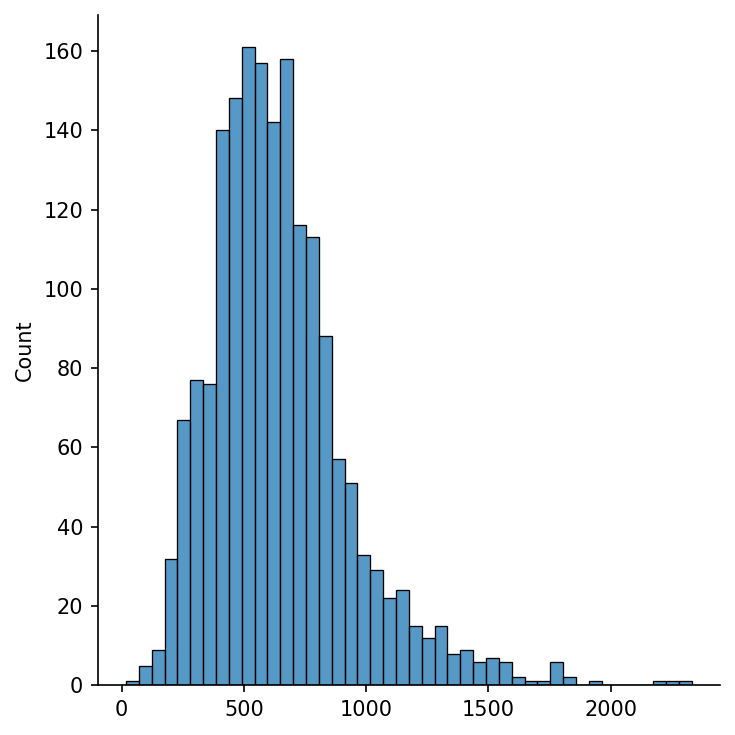

In [49]:
## Check the text len distribution
texts_lens = [len(n) for n in texts_ints]

import seaborn as sns

sns.displot(texts_lens)

In [50]:
## Find the maxlen of the texts
max_len = texts_lens[np.argmax(texts_lens)]
max_len

2331

In [51]:
## Padding
max_len = 400
texts_ints_pad = sequence.pad_sequences(texts_ints, maxlen=max_len, truncating='pre', padding='pre')
texts_ints_pad[:10]

array([[   8,    1,  382, ...,   85,   10, 1348],
       [   1,  485, 2386, ..., 5984,   29,   68],
       [ 425,    4, 2279, ...,  948,    4,   64],
       ...,
       [  20,    1,  172, ..., 1632,   14, 4732],
       [   0,    0,    0, ...,  459,    4, 2241],
       [ 158,   38, 5476, ...,   10,    2, 1338]], dtype=int32)

In [52]:
from os import truncate
## Generate X and y for training
X_train = np.array(texts_ints_pad).astype('int32')
y_train = np.array(labels)

## Generate X and y for testing in the same way
X_test_texts = [n for (n, l) in test_set]
X_test = np.array(sequence.pad_sequences(tokenizer.texts_to_sequences(X_test_texts),
                                         maxlen=max_len,
                                         padding='pre',
                                         truncating='pre')).astype('int32')
y_test = np.array([l for (n, l) in test_set])

In [53]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1800, 400)
(1800,)
(200, 400)
(200,)


### Text to Matrix (One-hot Encoding/Bag-of-Words)

In [54]:
## Texts to One-Hot Encoding (bag of words)
texts_matrix = tokenizer.texts_to_matrix(texts, mode='binary')
X_train2 = np.array(texts_matrix).astype('int32')
y_train2 = np.array(labels)

## Same for testing data
X_test2 = tokenizer.texts_to_matrix(X_test_texts, mode="binary").astype('int32')
y_test2 = np.array([l for (n, l) in test_set])

print(X_train2.shape)
print(y_train2.shape)
print(X_test2.shape)
print(y_test2.shape)

(1800, 10000)
(1800,)
(200, 10000)
(200,)


## Hyperparameters

In [55]:
BATCH_SIZE = 128
EPOCHS = 25
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 128

# Model Definition
## Part 1

In [56]:
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.dpi'] = 150

# Plotting results
def plot1(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc) + 1)
  ## Accuracy plot
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and Validation accuracy')
  plt.legend()
  ## Loss plot
  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and Validation loss')
  plt.legend()
  plt.show()

def plot2(history):
  pd.DataFrame(history.history).plot(figsize=(8, 5))
  plt.grid(True)
  plt.show()

### Model 1 (Feedforward Neural Network)

In [57]:
## Model 1
model1 = Sequential()
model1.add(Input(shape=(NUM_WORDS, )))
model1.add(Dense(16, activation='relu', name='dense_layer_1'))
model1.add(Dense(16, activation='relu', name='dense_layer_2'))
model1.add(Dense(1, activation='sigmoid', name='output'))

model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [58]:
plot_model(model1, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [59]:
history1 = model1.fit(X_train2, y_train2, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=2, validation_split=VALIDATION_SPLIT)

Epoch 1/25
12/12 - 1s - loss: 0.6674 - accuracy: 0.6243 - val_loss: 0.6177 - val_accuracy: 0.7833 - 844ms/epoch - 70ms/step
Epoch 2/25
12/12 - 0s - loss: 0.5114 - accuracy: 0.9014 - val_loss: 0.5178 - val_accuracy: 0.8278 - 89ms/epoch - 7ms/step
Epoch 3/25
12/12 - 0s - loss: 0.3534 - accuracy: 0.9549 - val_loss: 0.4269 - val_accuracy: 0.8361 - 90ms/epoch - 7ms/step
Epoch 4/25
12/12 - 0s - loss: 0.2146 - accuracy: 0.9792 - val_loss: 0.3614 - val_accuracy: 0.8639 - 89ms/epoch - 7ms/step
Epoch 5/25
12/12 - 0s - loss: 0.1216 - accuracy: 0.9944 - val_loss: 0.3346 - val_accuracy: 0.8639 - 89ms/epoch - 7ms/step
Epoch 6/25
12/12 - 0s - loss: 0.0699 - accuracy: 0.9986 - val_loss: 0.3036 - val_accuracy: 0.8611 - 88ms/epoch - 7ms/step
Epoch 7/25
12/12 - 0s - loss: 0.0401 - accuracy: 0.9993 - val_loss: 0.2900 - val_accuracy: 0.8722 - 88ms/epoch - 7ms/step
Epoch 8/25
12/12 - 0s - loss: 0.0248 - accuracy: 1.0000 - val_loss: 0.2850 - val_accuracy: 0.8806 - 89ms/epoch - 7ms/step
Epoch 9/25
12/12 - 0s 

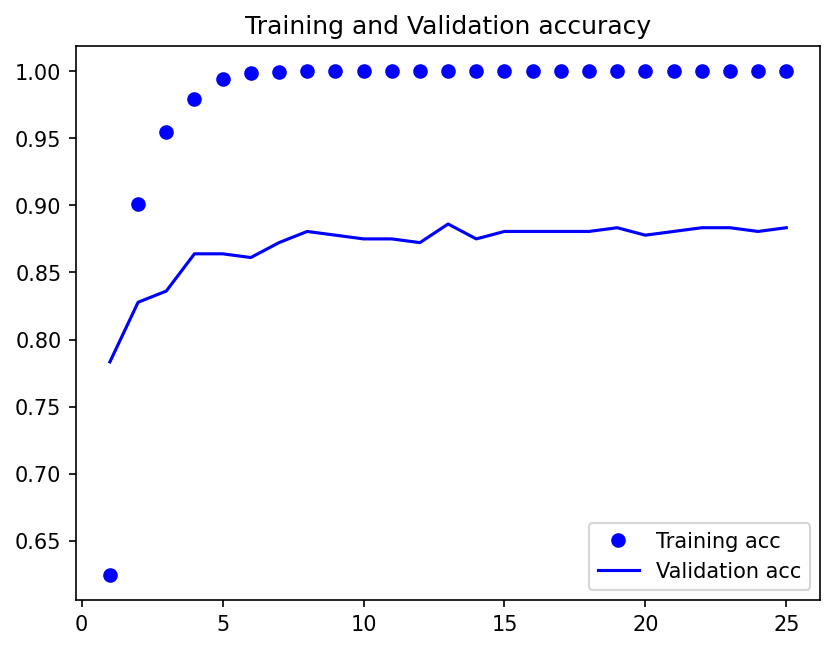

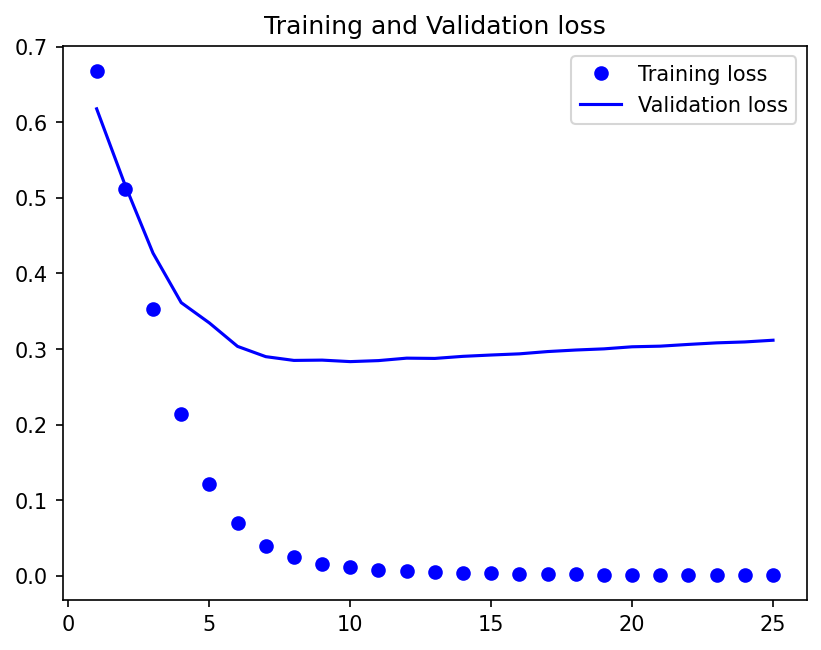

In [60]:
## Plot Training History
plot1(history1)

In [61]:
## Model Evaluation
model1.evaluate(X_test2, y_test2, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 0.3858 - accuracy: 0.8650 - 35ms/epoch - 18ms/step


[0.3858226537704468, 0.8650000095367432]

### Model 2 (Feedforward Neural Network)
#### Components:
1. One Embedding layer
2. Two-fully connected dense layers
3. The inputs are the sequences (integers) of texts

In [62]:
model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_len, mask_zero=True))
model2.add(GlobalAveragePooling1D()) # GlobalAveragePooling1D returns a fixed length output vector for each example by averaging over the sequence dimensions which allows the model to handle input of variable length, in the simplest way possible
model2.add(Dense(16, activation='relu', name='dense_layer_1'))
model2.add(Dense(16, activation='relu', name='dense_layer_2'))
model2.add(Dense(1, activation='sigmoid', name='output'))

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [63]:
plot_model(model2, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [64]:
history2 = model2.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=2, validation_split=VALIDATION_SPLIT)

Epoch 1/25
12/12 - 2s - loss: 0.6931 - accuracy: 0.4924 - val_loss: 0.6919 - val_accuracy: 0.7389 - 2s/epoch - 128ms/step
Epoch 2/25
12/12 - 0s - loss: 0.6905 - accuracy: 0.7903 - val_loss: 0.6889 - val_accuracy: 0.7167 - 199ms/epoch - 17ms/step
Epoch 3/25
12/12 - 0s - loss: 0.6854 - accuracy: 0.7882 - val_loss: 0.6836 - val_accuracy: 0.8250 - 222ms/epoch - 18ms/step
Epoch 4/25
12/12 - 0s - loss: 0.6759 - accuracy: 0.8618 - val_loss: 0.6739 - val_accuracy: 0.8056 - 197ms/epoch - 16ms/step
Epoch 5/25
12/12 - 0s - loss: 0.6589 - accuracy: 0.8861 - val_loss: 0.6580 - val_accuracy: 0.8361 - 194ms/epoch - 16ms/step
Epoch 6/25
12/12 - 0s - loss: 0.6306 - accuracy: 0.9049 - val_loss: 0.6332 - val_accuracy: 0.8306 - 196ms/epoch - 16ms/step
Epoch 7/25
12/12 - 0s - loss: 0.5868 - accuracy: 0.9271 - val_loss: 0.5971 - val_accuracy: 0.8389 - 193ms/epoch - 16ms/step
Epoch 8/25
12/12 - 0s - loss: 0.5249 - accuracy: 0.9354 - val_loss: 0.5501 - val_accuracy: 0.8500 - 195ms/epoch - 16ms/step
Epoch 9/25

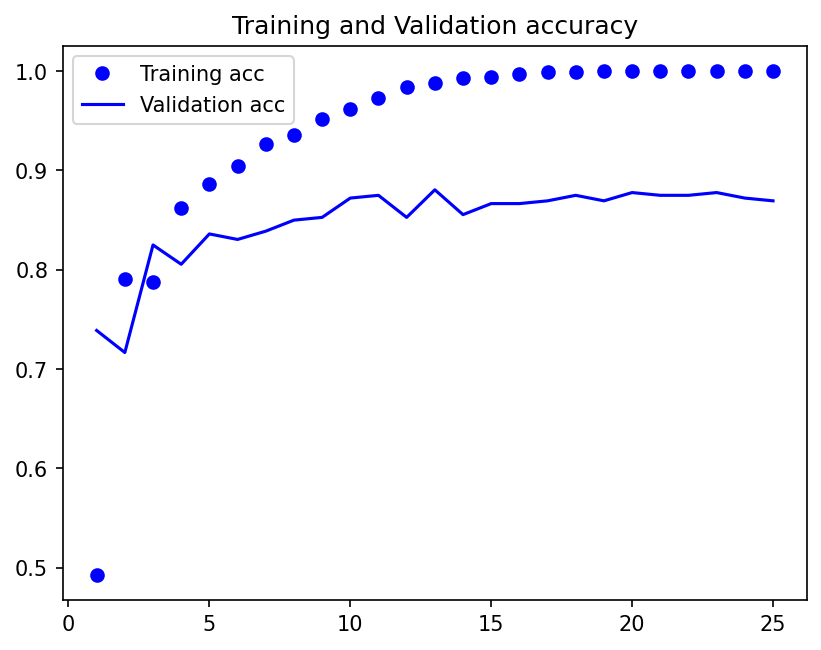

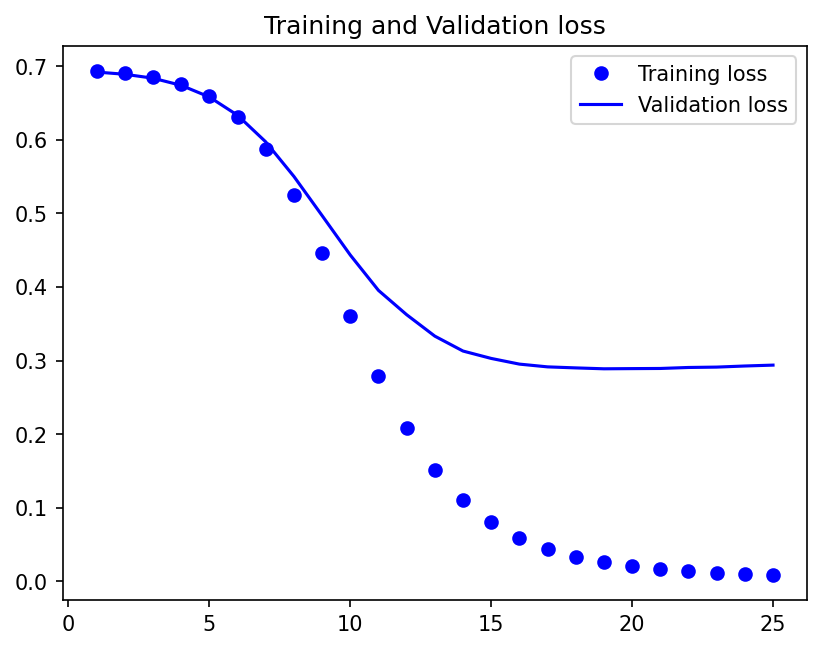

In [65]:
plot1(history2)

In [66]:
## Model Evaluation
model2.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 0.3719 - accuracy: 0.8650 - 32ms/epoch - 16ms/step


[0.3718527853488922, 0.8650000095367432]

## Part 2
### Model 3 (LSTM)

In [67]:
model3 = Sequential()
model3.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_len, mask_zero=True))
model3.add(LSTM(16, dropout=0.2, recurrent_dropout=0.2))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [68]:
plot_model(model3, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [69]:
history3 = model3.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=2, validation_split=VALIDATION_SPLIT)

Epoch 1/25
12/12 - 8s - loss: 0.6929 - accuracy: 0.5188 - val_loss: 0.6914 - val_accuracy: 0.5278 - 8s/epoch - 632ms/step
Epoch 2/25
12/12 - 4s - loss: 0.6775 - accuracy: 0.7375 - val_loss: 0.6853 - val_accuracy: 0.5778 - 4s/epoch - 345ms/step
Epoch 3/25
12/12 - 4s - loss: 0.6490 - accuracy: 0.8375 - val_loss: 0.6703 - val_accuracy: 0.6278 - 4s/epoch - 350ms/step
Epoch 4/25
12/12 - 4s - loss: 0.5714 - accuracy: 0.8687 - val_loss: 0.6244 - val_accuracy: 0.6556 - 4s/epoch - 354ms/step
Epoch 5/25
12/12 - 4s - loss: 0.4037 - accuracy: 0.8806 - val_loss: 0.6213 - val_accuracy: 0.7056 - 4s/epoch - 353ms/step
Epoch 6/25
12/12 - 4s - loss: 0.2815 - accuracy: 0.9333 - val_loss: 0.5495 - val_accuracy: 0.7278 - 4s/epoch - 344ms/step
Epoch 7/25
12/12 - 4s - loss: 0.1851 - accuracy: 0.9674 - val_loss: 0.5821 - val_accuracy: 0.7278 - 4s/epoch - 350ms/step
Epoch 8/25
12/12 - 4s - loss: 0.1354 - accuracy: 0.9743 - val_loss: 0.5652 - val_accuracy: 0.7472 - 4s/epoch - 355ms/step
Epoch 9/25
12/12 - 4s - 

In [70]:
model3.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 0.9651 - accuracy: 0.7200 - 127ms/epoch - 64ms/step


[0.9651007056236267, 0.7200000286102295]

### Model 4 (Stacked LSTM)

In [71]:
model4 = Sequential()
model4.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_len, mask_zero=True))
model4.add(LSTM(16, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model4.add(LSTM(16, dropout=0.2, recurrent_dropout=0.2))
model4.add(Dense(1, activation="sigmoid"))
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [72]:
plot_model(model4, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [73]:
history4 = model4.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=2, validation_split=0.2)

Epoch 1/25
12/12 - 14s - loss: 0.6928 - accuracy: 0.5146 - val_loss: 0.6925 - val_accuracy: 0.5111 - 14s/epoch - 1s/step
Epoch 2/25
12/12 - 8s - loss: 0.6868 - accuracy: 0.5778 - val_loss: 0.6888 - val_accuracy: 0.5472 - 8s/epoch - 683ms/step
Epoch 3/25
12/12 - 8s - loss: 0.6594 - accuracy: 0.7854 - val_loss: 0.6665 - val_accuracy: 0.6222 - 8s/epoch - 664ms/step
Epoch 4/25
12/12 - 8s - loss: 0.5282 - accuracy: 0.8521 - val_loss: 0.5736 - val_accuracy: 0.7083 - 8s/epoch - 668ms/step
Epoch 5/25
12/12 - 8s - loss: 0.3136 - accuracy: 0.9000 - val_loss: 0.5512 - val_accuracy: 0.7389 - 8s/epoch - 687ms/step
Epoch 6/25
12/12 - 8s - loss: 0.1970 - accuracy: 0.9618 - val_loss: 0.5802 - val_accuracy: 0.7389 - 8s/epoch - 679ms/step
Epoch 7/25
12/12 - 8s - loss: 0.1194 - accuracy: 0.9819 - val_loss: 0.6008 - val_accuracy: 0.7500 - 8s/epoch - 697ms/step
Epoch 8/25
12/12 - 8s - loss: 0.0767 - accuracy: 0.9944 - val_loss: 0.7199 - val_accuracy: 0.7278 - 8s/epoch - 684ms/step
Epoch 9/25
12/12 - 8s - l

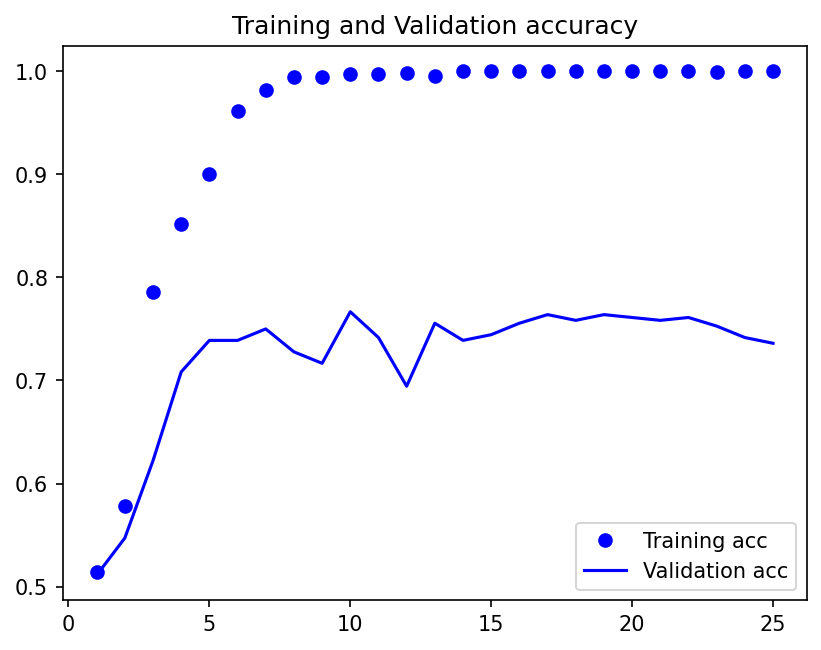

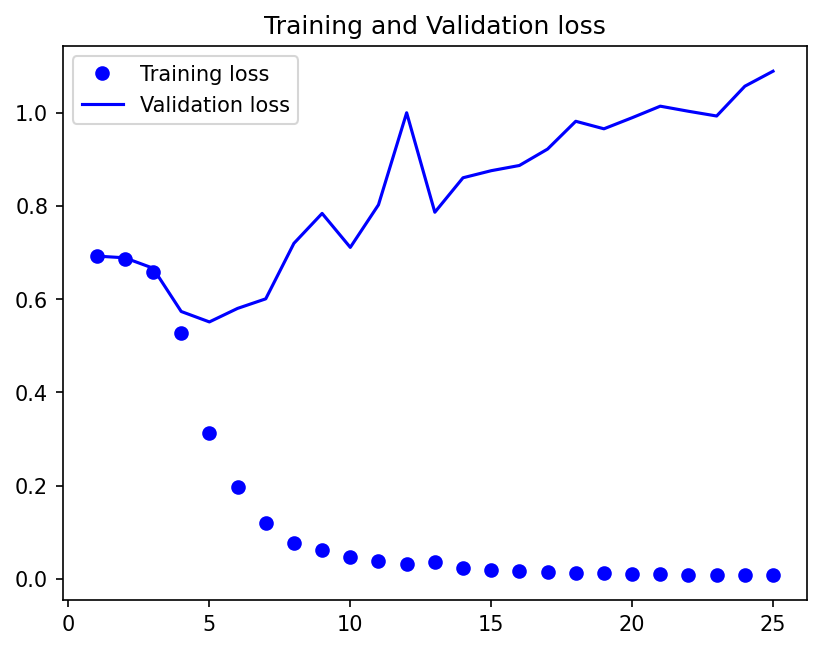

In [74]:
plot1(history4)

In [75]:
model4.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 1.1600 - accuracy: 0.7150 - 230ms/epoch - 115ms/step


[1.159989833831787, 0.7149999737739563]

### Model 5 (Bidirectional LSTM)

In [76]:
model5 = Sequential()
model5.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_len, mask_zero=True))
model5.add(Bidirectional(LSTM(16, dropout=0.2, recurrent_dropout=0.2)))
model5.add(Dense(1, activation="sigmoid"))
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [77]:
plot_model(model5, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [78]:
history5 = model5.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=2, validation_split=0.2)

Epoch 1/25
12/12 - 12s - loss: 0.6924 - accuracy: 0.5160 - val_loss: 0.6910 - val_accuracy: 0.5417 - 12s/epoch - 1s/step
Epoch 2/25
12/12 - 5s - loss: 0.6770 - accuracy: 0.7965 - val_loss: 0.6864 - val_accuracy: 0.6111 - 5s/epoch - 411ms/step
Epoch 3/25
12/12 - 5s - loss: 0.6478 - accuracy: 0.9035 - val_loss: 0.6744 - val_accuracy: 0.6111 - 5s/epoch - 405ms/step
Epoch 4/25
12/12 - 5s - loss: 0.5493 - accuracy: 0.8799 - val_loss: 0.6511 - val_accuracy: 0.6306 - 5s/epoch - 443ms/step
Epoch 5/25
12/12 - 5s - loss: 0.4721 - accuracy: 0.7576 - val_loss: 0.5562 - val_accuracy: 0.7250 - 5s/epoch - 422ms/step
Epoch 6/25
12/12 - 5s - loss: 0.3293 - accuracy: 0.9403 - val_loss: 0.5358 - val_accuracy: 0.7278 - 5s/epoch - 419ms/step
Epoch 7/25
12/12 - 5s - loss: 0.2216 - accuracy: 0.9715 - val_loss: 0.5073 - val_accuracy: 0.7389 - 5s/epoch - 417ms/step
Epoch 8/25
12/12 - 5s - loss: 0.1431 - accuracy: 0.9847 - val_loss: 0.4832 - val_accuracy: 0.7528 - 5s/epoch - 411ms/step
Epoch 9/25
12/12 - 5s - l

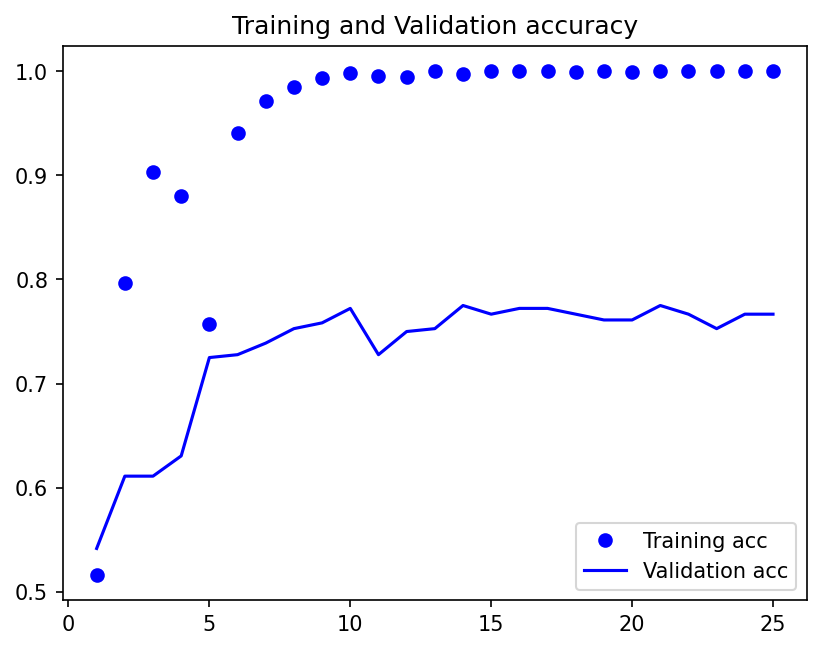

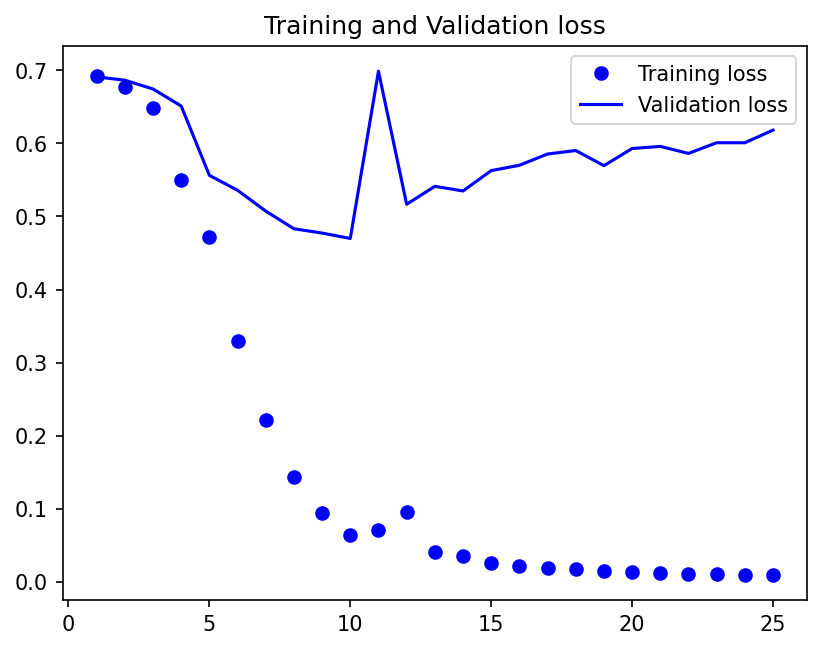

In [79]:
plot1(history5)

In [80]:
model5.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 0.5611 - accuracy: 0.8050 - 144ms/epoch - 72ms/step


[0.5610867142677307, 0.8050000071525574]

### Model 6 (LSTM + Dense)

In [81]:
inputs = Input(shape=(max_len, ))
x = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_len, mask_zero=True)(inputs)
_, x_last_h, x_c = LSTM(16, dropout=0.2, recurrent_dropout=0.2, return_sequences=False, return_state=True)(x)
x = Concatenate(axis=1)([x_last_h, x_c])
outputs = Dense(1, activation='sigmoid')(x)
model6 = Model(inputs=inputs, outputs=outputs)

plot_model(model6, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [82]:
model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history6 = model6.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=2, validation_split=VALIDATION_SPLIT)

Epoch 1/25
12/12 - 8s - loss: 0.6914 - accuracy: 0.5472 - val_loss: 0.6871 - val_accuracy: 0.6417 - 8s/epoch - 637ms/step
Epoch 2/25
12/12 - 4s - loss: 0.6659 - accuracy: 0.7819 - val_loss: 0.6757 - val_accuracy: 0.6306 - 4s/epoch - 354ms/step
Epoch 3/25
12/12 - 4s - loss: 0.6092 - accuracy: 0.8292 - val_loss: 0.6345 - val_accuracy: 0.6639 - 4s/epoch - 346ms/step
Epoch 4/25
12/12 - 4s - loss: 0.4302 - accuracy: 0.8750 - val_loss: 0.4922 - val_accuracy: 0.7500 - 4s/epoch - 343ms/step
Epoch 5/25
12/12 - 4s - loss: 0.2432 - accuracy: 0.9194 - val_loss: 0.4654 - val_accuracy: 0.7806 - 4s/epoch - 342ms/step
Epoch 6/25
12/12 - 4s - loss: 0.1427 - accuracy: 0.9618 - val_loss: 0.4661 - val_accuracy: 0.7722 - 4s/epoch - 343ms/step
Epoch 7/25
12/12 - 4s - loss: 0.1241 - accuracy: 0.9611 - val_loss: 0.5081 - val_accuracy: 0.7639 - 4s/epoch - 343ms/step
Epoch 8/25
12/12 - 4s - loss: 0.0664 - accuracy: 0.9924 - val_loss: 0.5107 - val_accuracy: 0.8000 - 4s/epoch - 345ms/step
Epoch 9/25
12/12 - 4s - 

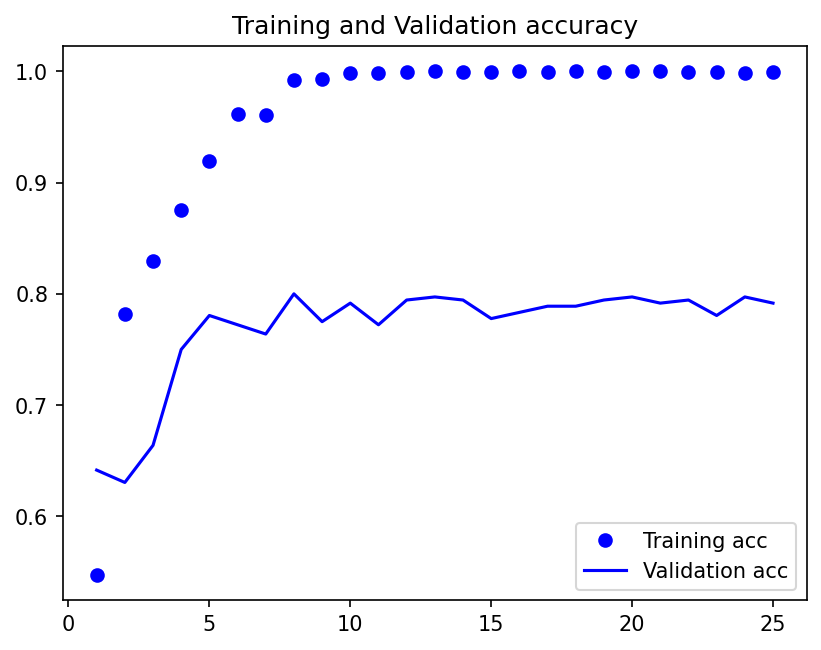

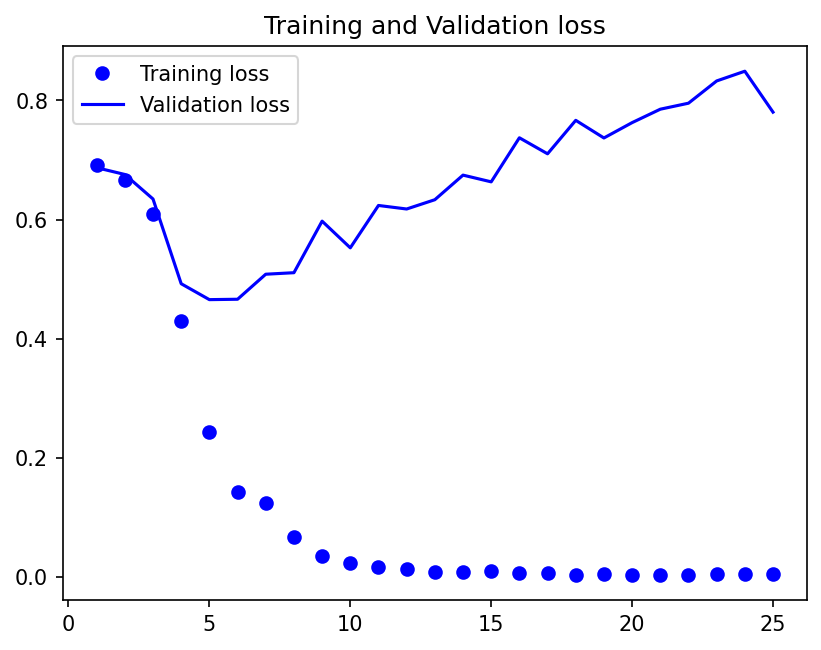

In [83]:
plot1(history6)

In [84]:
model6.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 0.7920 - accuracy: 0.8050 - 153ms/epoch - 77ms/step


[0.7919968962669373, 0.8050000071525574]

### Model 6 (LSTM + Attention)

In [85]:
inputs = Input(shape=(max_len, ))
x = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_len,mask_zero=True)(inputs)
x_all_hs, x_last_h, x_last_c = LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, return_state=True)(x)

## Self Attention
atten_out = Attention()([x_all_hs, x_all_hs]) # query and key
atten_out_average = GlobalAveragePooling1D()(atten_out)

x_last_h_plus_atten = Concatenate()([x_last_h, atten_out_average])
x = Dense(16, activation='relu')(x_last_h_plus_atten)
outputs = Dense(1, activation='sigmoid')(x)
model7 = Model(inputs=inputs, outputs=outputs)

plot_model(model7, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [86]:
model7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history7 = model7.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=2, validation_split=VALIDATION_SPLIT)

Epoch 1/25
12/12 - 12s - loss: 0.6925 - accuracy: 0.5375 - val_loss: 0.6917 - val_accuracy: 0.5528 - 12s/epoch - 1s/step
Epoch 2/25
12/12 - 8s - loss: 0.6825 - accuracy: 0.7479 - val_loss: 0.6862 - val_accuracy: 0.5778 - 8s/epoch - 682ms/step
Epoch 3/25
12/12 - 8s - loss: 0.6437 - accuracy: 0.8090 - val_loss: 0.6198 - val_accuracy: 0.6944 - 8s/epoch - 678ms/step
Epoch 4/25
12/12 - 8s - loss: 0.4670 - accuracy: 0.8556 - val_loss: 0.4792 - val_accuracy: 0.8167 - 8s/epoch - 687ms/step
Epoch 5/25
12/12 - 8s - loss: 0.2740 - accuracy: 0.9285 - val_loss: 0.4707 - val_accuracy: 0.7861 - 8s/epoch - 672ms/step
Epoch 6/25
12/12 - 8s - loss: 0.1440 - accuracy: 0.9674 - val_loss: 0.4315 - val_accuracy: 0.8222 - 8s/epoch - 681ms/step
Epoch 7/25
12/12 - 8s - loss: 0.1318 - accuracy: 0.9694 - val_loss: 0.4421 - val_accuracy: 0.8056 - 8s/epoch - 676ms/step
Epoch 8/25
12/12 - 8s - loss: 0.0608 - accuracy: 0.9868 - val_loss: 0.6516 - val_accuracy: 0.8083 - 8s/epoch - 665ms/step
Epoch 9/25
12/12 - 8s - l

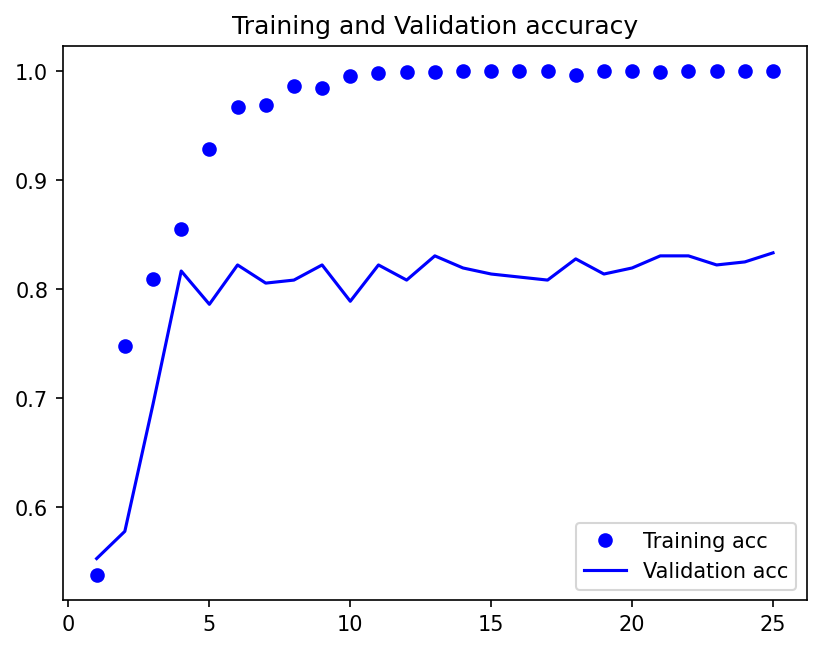

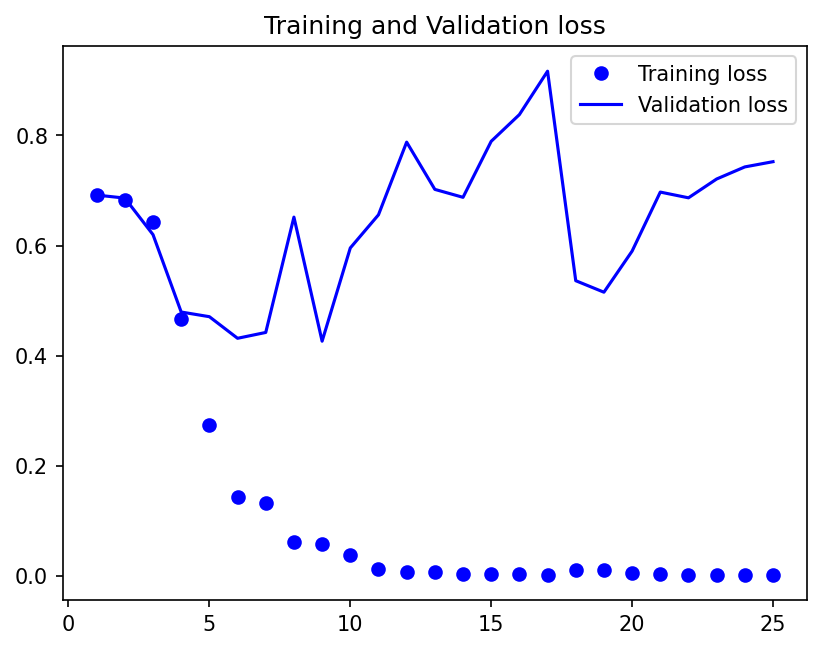

In [87]:
plot1(history7)

In [88]:
model7.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 0.9461 - accuracy: 0.8000 - 374ms/epoch - 187ms/step


[0.9461376667022705, 0.800000011920929]

# Explanation

In [89]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=14feba4dd73e09bf957984a4826155a2745ef31089cc9392e8d78762256bf0e0
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [90]:
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=['negative', 'positive'], char_level=False)

best_model = model7

def model_prediction_pipeline(text):
  _seq = tokenizer.texts_to_sequences(text)
  _seq_pad = keras.preprocessing.sequence.pad_sequences(_seq, maxlen=max_len)
  return np.array([[float(1-x), float(x)] for x in best_model.predict(np.array(_seq_pad))])

text_id = 3
exp = explainer.explain_instance(X_test_texts[text_id], model_prediction_pipeline, num_features=20, top_labels=1)
exp.show_in_notebook(text=True)

157/157 [==============================] - 11s 65ms/step


<ipython-input-90-66135ad1a7ad>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.array([[float(1-x), float(x)] for x in best_model.predict(np.array(_seq_pad))])


In [91]:
word_vectors = best_model.layers[1].get_weights()[0]
word_vectors.shape

(10001, 128)

In [92]:
token_labels = [
    word for (ind, word) in tokenizer.index_word.items() if ind < word_vectors.shape[0]
]
token_labels.insert(0, "PAD")
token_labels[:10]

['PAD', 'the', 'a', 'and', 'of', 'to', "'", 'is', 'in', 's']

In [93]:
len(token_labels)

10001

In [95]:
from sklearn.manifold import TSNE

stopword_list = nltk.corpus.stopwords.words('english')

In [96]:
out_index = [
    i for i, w in enumerate(token_labels)
    if len(w) >= 5 and w not in stopword_list
]
len(out_index)

8226

In [97]:
out_index[:10]

[27, 69, 70, 73, 82, 83, 95, 98, 99, 102]

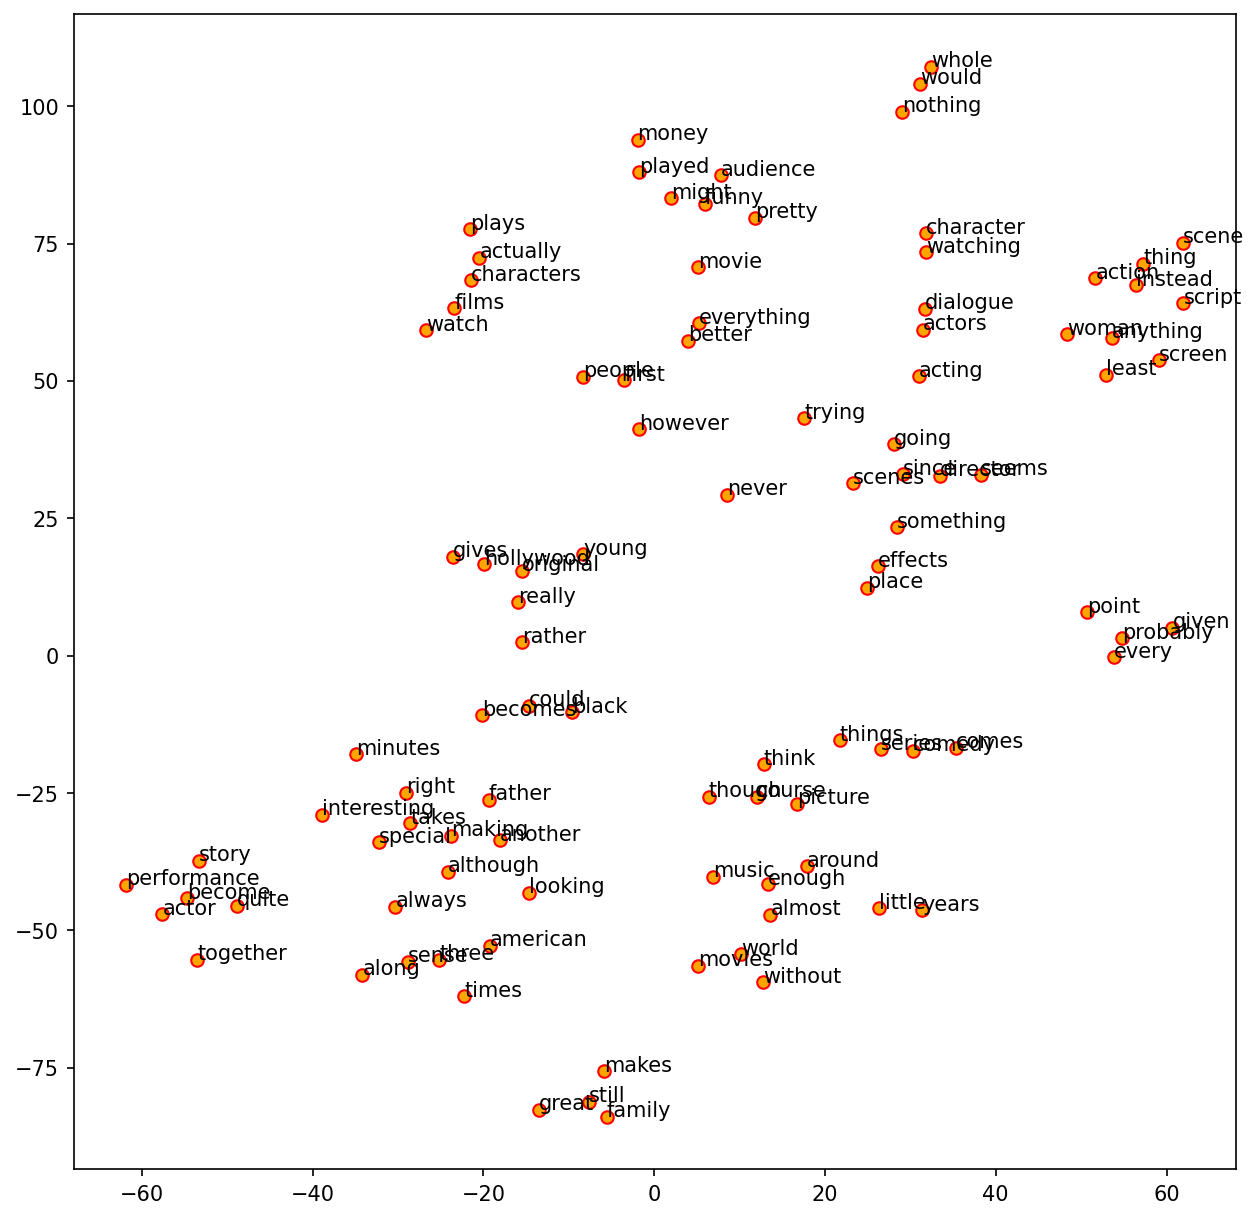

In [98]:
tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors[out_index[:100], ])
labels = list(np.array(token_labels)[out_index[:100]])

len(labels)

plt.figure(figsize=(10, 10), dpi=150)
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 0.01, y + 0.01),
                 xytext=(0, 0),
                 textcoords='offset points')

# Model Comparisons

In [99]:
history = [
    history1, history2, history3, history4, history5, history6, history7
]
history = [i.history for i in history]
model_names = [
    'One-hot-dense', 'Embedding-dense', 'RNN', 'Two-RNN', 'Bidirect',
    'Hidden-Cell', 'Self-attention'
]

## Set color pallete
import seaborn as sns
qualitative_colors = sns.color_palette("Paired", len(history))

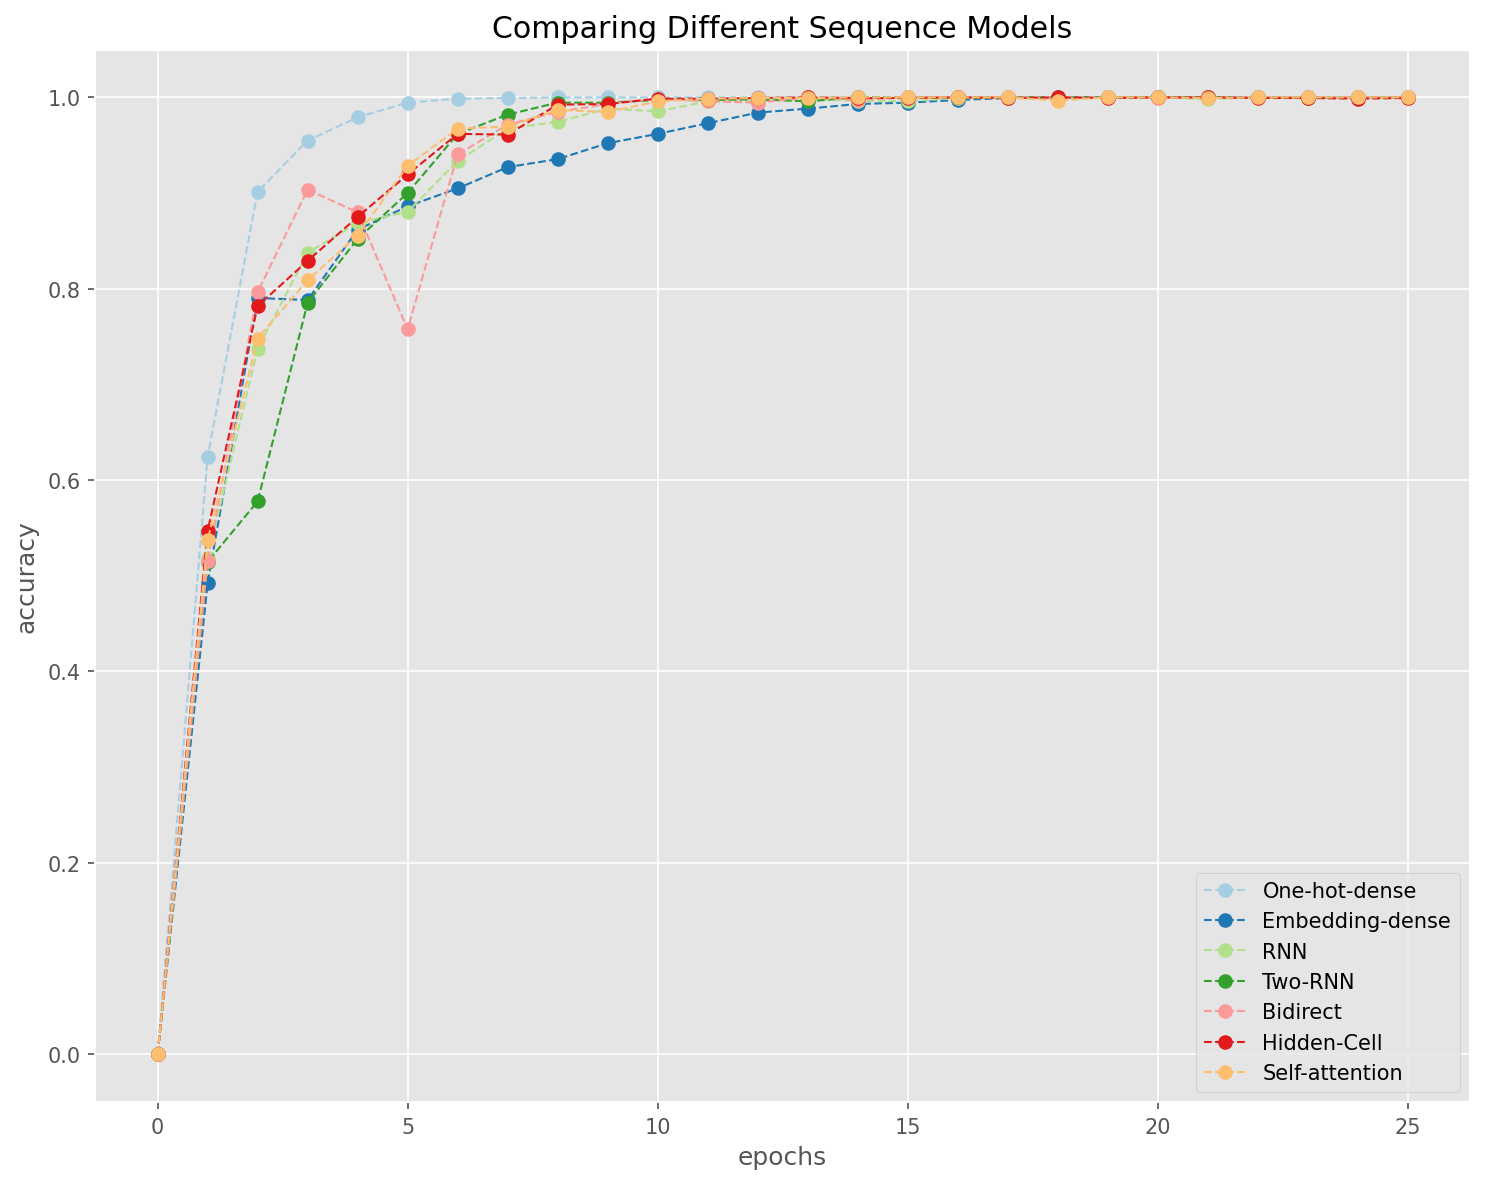

In [100]:
## Accuracy
acc = [i['accuracy'] for i in history]
val_acc = [i['val_accuracy'] for i in history]

plt.figure(figsize=(10, 8))
plt.style.use('ggplot')
for i, a in enumerate(acc):
    plt.plot(range(len(a) + 1), [0] + a,
             linestyle='--',
             marker='o',
             color=qualitative_colors[i],
             linewidth=1,
             label=model_names[i])
plt.legend()
plt.title('Comparing Different Sequence Models')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.tight_layout()
plt.show()

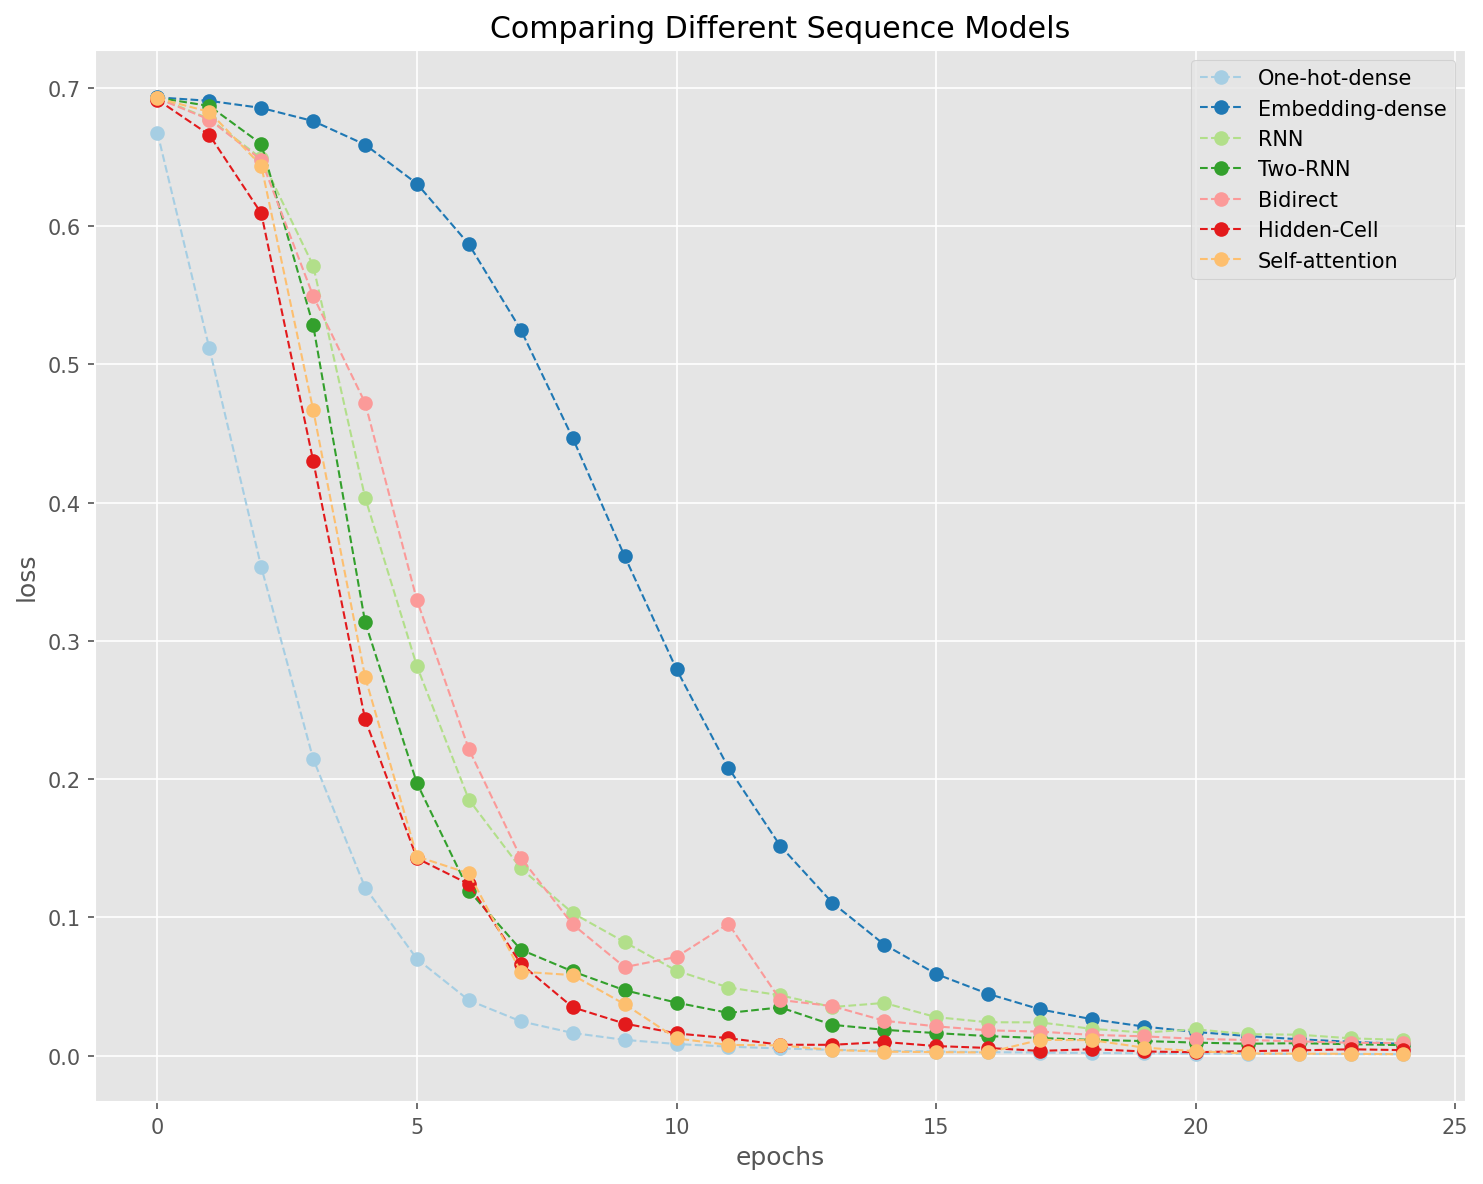

In [101]:
loss = [i['loss'] for i in history]

plt.figure(figsize=(10, 8))
plt.style.use('ggplot')
for i, a in enumerate(loss):
    plt.plot(range(len(a)),
             a,
             linestyle='--',
             marker='o',
             color=qualitative_colors[i],
             linewidth=1,
             label=model_names[i])
plt.legend()
plt.title('Comparing Different Sequence Models')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.tight_layout()
plt.show()